# ASR Assignment 2022-23

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2022-23/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


[['ey'], ['ah', 'v'], ['p', 'eh', 'k'], ['p', 'eh', 'p', 'er', 'z'], ['p', 'iy', 't', 'er'], ['p', 'ih', 'k', 't'], ['p', 'ih', 'k', 'ah', 'l', 'd'], ['p', 'ay', 'p', 'er'], ['dh', 'iy'], ['w', 'eh', 'r', 'z']]


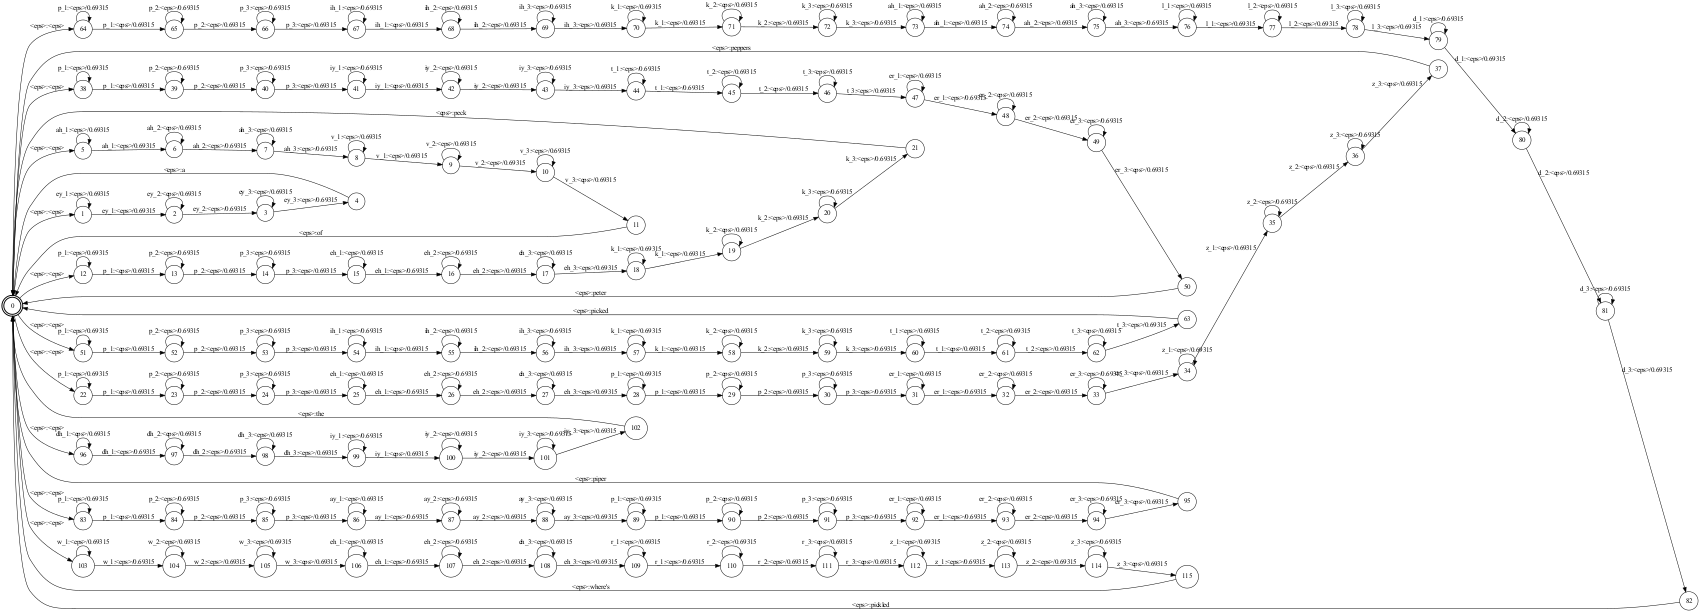

In [1]:
import glob
import os
import wer
import observation_model
import openfst_python as fst

# ... (add your code to create WFSTs and Viterbi Decoder)
import observation_model
import math
import openfst_python as fst
import time

class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        
        forward_computations = 0
          
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        forward_computations += 1
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                                
        return forward_computations
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        forward_computations = 0
        initial = time.time()
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            forward_computations += self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
        final=time.time()
        return (forward_computations, (final - initial))
    
    def backtrace(self):
        
        initial = time.time()
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        
        
        final = time.time()
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence =' '.join([ self.f.output_symbols().find(label) for label in best_out_sequence])
        return (best_state_sequence, best_out_sequence,(final-initial))
import openfst_python as fst

def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex

def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))
            
    return word_table, phone_table, state_table


# call these two functions
lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)
def generate_phone_wfst(f, start_state, phone, n, next_state_prob):
    """
    Generate a WFST representing an n-state left-to-right phone HMM.
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        phone (str): the phone label 
        n (int): number of states of the HMM excluding start and end
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    
    for i in range(1, n+1):
    
        in_label = state_table.find('{}_{}'.format(phone, i))
        sl_weight = fst.Weight('log', -math.log(1-next_state_prob))
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, sl_weight, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        
        out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        next_weight = fst.Weight('log', -math.log(next_state_prob))
        f.add_arc(current_state, fst.Arc(in_label, out_label, next_weight, next_state))    
       
        current_state = next_state
    return current_state



def create_wfst(n, probabilities=None, next_state_prob=0.5):
    """ Generate a WFST for any word in the lexicon, composed of n-state phone WFSTs.
        This will currently output phone labels.  
    
    Args:
        
        start_state (int): the index of the first state, assumed to exist already
        word (str): the word to generate
        n (int): states per phone HMM
        
    Returns:
        the constructed WFST
    
    """
    f = fst.Fst('log')
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    f.set_final(start_state)
    start_weight= fst.Weight('log', -math.log(1))
    for word, phones in lex.items():
        if probabilities:
            start_weight = fst.Weight('log', -math.log(probabilities[word]))
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0,start_weight , current_state))
        
        for phone in phones: 
            current_state = generate_phone_wfst(f, current_state, phone, n,next_state_prob)
        # note: new current_state is now set to the final state of the previous phone WFST
        
        next_weight = fst.Weight('log', -math.log(1))
        out_label = word_table.find(word)
        f.add_arc(current_state, fst.Arc(0, out_label,next_weight , start_state))
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)

    return f




    


def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription


f = create_wfst(3)

print([x for x in lex.values()])

def num_states(f):
    counter = 0
    for x in f.states():
        counter += 1
    return counter

def total_num_arcs(f):
    return sum(f.num_arcs(s) for s in f.states())

def draw_fst(f):
    from subprocess import check_call
    from IPython.display import Image
    f.draw('tmp.dot', portrait=True)
    check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
    return Image(filename='tmp.png')




draw_fst(f)

    

In [2]:
#TASK 1

!pip install pandas
import pandas as pd
results_df=[]
import wer

print(num_states(f))
print(total_num_arcs(f))

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                           # audio files
    break
    decoder = MyViterbiDecoder(f, wav_file)
    
    forward_computations, decode_speed = decoder.decode()
    print(decode_speed)
    (state_path, words, backtrace_speed) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
    # to return the words along the best path
    print(backtrace_speed)
    
    transcription = read_transcription(wav_file)
    
    word_count = len(transcription.split())
    



    
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())
    worderror = sum(error_counts)/word_count
         # you'll need to accumulate these to produce an overall Word Error Rate
    filename = wav_file.split('/')[-1]
    row = {
        'Filename': filename,
        'Insertions': error_counts[2],
        'Deletions': error_counts[1],
        'Substitutions': error_counts[0],
        'WER': worderror,
        'Word Count': word_count,
        'transcription':transcription,
        'Viterbi transcription':words,
        'Decode speed': decode_speed,
        'Backtrace speed': backtrace_speed,
        'Forward computations': forward_computations
    }
    print(row)
    
    
    # Append results to the DataFrame
    results_df.append(row)
    
results_df = pd.DataFrame(results_df)
# Save the DataFrame to a CSV file
# results_df.to_csv('resulto.csv')



116
230


In [3]:
from collections import defaultdict
word_count=defaultdict(int)

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                           # audio files
    transcription = read_transcription(wav_file)
    for word in transcription.split(" "):
        word_count[word]+=1
total_words = sum(word_count.values())
probabilities ={word:count/total_words for word,count in word_count.items()}
print(word_count,probabilities)

defaultdict(<class 'int'>, {'peter': 338, 'piper': 289, 'picked': 286, 'a': 138, 'peck': 264, 'of': 246, 'pickled': 285, 'peppers': 321, "where's": 118, 'the': 137}) {'peter': 0.13955408753096615, 'piper': 0.11932287365813378, 'picked': 0.1180842279108175, 'a': 0.05697770437654831, 'peck': 0.10900082576383155, 'of': 0.10156895127993394, 'pickled': 0.11767134599504542, 'peppers': 0.13253509496284063, "where's": 0.04872006606110652, 'the': 0.056564822460776217}


In [4]:
#TASK 2, using the above probabilities to change the word probabilties
!pip install pandas
import pandas as pd
results_df=[]
import wer
f= create_wfst(3,probabilities)
print(num_states(f))
print(total_num_arcs(f))

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
    break                     # audio files
    decoder = MyViterbiDecoder(f, wav_file)
    
    forward_computations, decode_speed = decoder.decode()
    print(decode_speed)
    (state_path, words, backtrace_speed) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
    # to return the words along the best path
    print(backtrace_speed)
    
    transcription = read_transcription(wav_file)
    
    word_count = len(transcription.split())
    



    
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())
    worderror = sum(error_counts)/word_count
         # you'll need to accumulate these to produce an overall Word Error Rate
    filename = wav_file.split('/')[-1]
    row = {
        'Filename': filename,
        'Insertions': error_counts[2],
        'Deletions': error_counts[1],
        'Substitutions': error_counts[0],
        'WER': worderror,
        'Word Count': word_count,
        'transcription':transcription,
        'Viterbi transcription':words,
        'Decode speed': decode_speed,
        'Backtrace speed': backtrace_speed,
        'Forward computations': forward_computations
    }
    print(row)
    
    
    # Append results to the DataFrame
    results_df.append(row)
    
results_df = pd.DataFrame(results_df)
# Save the DataFrame to a CSV file
# results_df.to_csv('result_unary.csv')



116
230


In [58]:
#TASK 2, changing self-loop probabilities
!pip install pandas
import pandas as pd
results_df=[]
import wer
f= create_wfst(3,next_state_prob=0.7)
print(num_states(f))
print(total_num_arcs(f))

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
    break                                                               # audio files
    
    decoder = MyViterbiDecoder(f, wav_file)
    
    forward_computations, decode_speed = decoder.decode()
    print(decode_speed)
    (state_path, words, backtrace_speed) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
    # to return the words along the best path
    print(backtrace_speed)
    
    transcription = read_transcription(wav_file)
    
    word_count = len(transcription.split())
    



    
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())
    worderror = sum(error_counts)/word_count
         # you'll need to accumulate these to produce an overall Word Error Rate
    filename = wav_file.split('/')[-1]
    row = {
        'Filename': filename,
        'Insertions': error_counts[2],
        'Deletions': error_counts[1],
        'Substitutions': error_counts[0],
        'WER': worderror,
        'Word Count': word_count,
        'transcription':transcription,
        'Viterbi transcription':words,
        'Decode speed': decode_speed,
        'Backtrace speed': backtrace_speed,
        'Forward computations': forward_computations
    }
    print(row)
    
    
    # Append results to the DataFrame
    results_df.append(row)
    
results_df = pd.DataFrame(results_df)
# Save the DataFrame to a CSV file
# results_df.to_csv('result_0.7.csv')



116
230
5.9021501541137695
0.0020401477813720703
{'Filename': '0000.wav', 'Insertions': 5, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.35294117647058826, 'Word Count': 17, 'transcription': "peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': "pickled the peter piper the peck a the peck of pickled peppers where's the peck of pickled peppers peter piper picked the", 'Decode speed': 5.9021501541137695, 'Backtrace speed': 0.0020401477813720703, 'Forward computations': 240318}
3.360806941986084
0.0011532306671142578
{'Filename': '0001.wav', 'Insertions': 7, 'Deletions': 0, 'Substitutions': 1, 'WER': 1.1428571428571428, 'Word Count': 7, 'transcription': 'peter picked a peck of pickled peppers', 'Viterbi transcription': 'pickled the picked a the peter picked the of peck of pickled peppers the', 'Decode speed': 3.360806941986084, 'Backtrace speed': 0.0011532306671142578, 'Forward computations': 136368}
2.57500886917114

3.4973068237304688
0.001405954360961914
{'Filename': '0020.wav', 'Insertions': 10, 'Deletions': 0, 'Substitutions': 2, 'WER': 1.7142857142857142, 'Word Count': 7, 'transcription': "peppers picked peter piper where's the peck", 'Viterbi transcription': "the peppers picked the picked piper the a picked the where's the picked the a picked the", 'Decode speed': 3.4973068237304688, 'Backtrace speed': 0.001405954360961914, 'Forward computations': 141828}
4.905402183532715
0.0019161701202392578
{'Filename': '0021.wav', 'Insertions': 11, 'Deletions': 0, 'Substitutions': 2, 'WER': 1.3, 'Word Count': 10, 'transcription': 'peter picked a peck piper pickled peppers of pickled peppers', 'Viterbi transcription': "picked the peter where's picked of peck picked piper the of pickled the of peppers of the pickled peck where's the", 'Decode speed': 4.905402183532715, 'Backtrace speed': 0.0019161701202392578, 'Forward computations': 200838}
3.6813464164733887
0.0013401508331298828
{'Filename': '0022.wav',

2.346174955368042
0.0008330345153808594
{'Filename': '0040.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.625, 'Word Count': 8, 'transcription': "piper peter picked where's the pickled peppers peter", 'Viterbi transcription': "picked the peck peter picked where's the pickled peppers peter a the", 'Decode speed': 2.346174955368042, 'Backtrace speed': 0.0008330345153808594, 'Forward computations': 96888}
1.8600380420684814
0.0011894702911376953
{'Filename': '0041.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.7142857142857143, 'Word Count': 7, 'transcription': 'peck pickled piper of the peter peppers', 'Viterbi transcription': 'picked the peck pickled a picked of the peter peppers the', 'Decode speed': 1.8600380420684814, 'Backtrace speed': 0.0011894702911376953, 'Forward computations': 75468}
2.2597224712371826
0.0011227130889892578
{'Filename': '0042.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 2, 'WER': 0.36363636363636365, 'Word Co

1.6265997886657715
0.000263214111328125
{'Filename': '0060.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.8, 'Word Count': 5, 'transcription': 'peck piper peter pickled picked', 'Viterbi transcription': 'peck the peck piper peter of pickled picked the', 'Decode speed': 1.6265997886657715, 'Backtrace speed': 0.000263214111328125, 'Forward computations': 66438}
1.8538017272949219
0.000583648681640625
{'Filename': '0061.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.8, 'Word Count': 5, 'transcription': 'peck peppers pickled peter piper', 'Viterbi transcription': 'peck the peck peppers pickled peter piper picked the', 'Decode speed': 1.8538017272949219, 'Backtrace speed': 0.000583648681640625, 'Forward computations': 75468}
4.721723318099976
0.001988649368286133
{'Filename': '0062.wav', 'Insertions': 7, 'Deletions': 1, 'Substitutions': 3, 'WER': 0.6470588235294118, 'Word Count': 17, 'transcription': "peter piper picked a peck of pickled peppers whe

2.111694812774658
0.0005676746368408203
{'Filename': '0079.wav', 'Insertions': 5, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.8333333333333334, 'Word Count': 6, 'transcription': 'piper picked peter of the peck', 'Viterbi transcription': 'a the piper picked the peter of the peck picked the', 'Decode speed': 2.111694812774658, 'Backtrace speed': 0.0005676746368408203, 'Forward computations': 88068}
2.7528676986694336
0.0008866786956787109
{'Filename': '0080.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.625, 'Word Count': 8, 'transcription': 'a peter picked peck of picked pickled piper', 'Viterbi transcription': 'picked the peck peter picked peck of picked pickled piper picked the', 'Decode speed': 2.7528676986694336, 'Backtrace speed': 0.0008866786956787109, 'Forward computations': 113058}
2.70048189163208
0.0009138584136962891
{'Filename': '0081.wav', 'Insertions': 6, 'Deletions': 0, 'Substitutions': 0, 'WER': 1.2, 'Word Count': 5, 'transcription': "where's peck p

4.037883281707764
0.0016112327575683594
{'Filename': '0099.wav', 'Insertions': 5, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.5454545454545454, 'Word Count': 11, 'transcription': "the peck pickled peppers picked pickled peter of piper a where's", 'Viterbi transcription': "picked the picked a picked pickled peppers picked peck pickled peter of piper a where's the", 'Decode speed': 4.037883281707764, 'Backtrace speed': 0.0016112327575683594, 'Forward computations': 165138}
2.84091854095459
0.00034689903259277344
{'Filename': '0100.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.4, 'Word Count': 10, 'transcription': 'the picked of piper picked of pickled a peter piper', 'Viterbi transcription': 'picked the picked of piper picked of pickled a the peter piper picked the', 'Decode speed': 2.84091854095459, 'Backtrace speed': 0.00034689903259277344, 'Forward computations': 118518}
4.7674970626831055
0.0019783973693847656
{'Filename': '0101.wav', 'Insertions': 7, 'Deletion

2.6626970767974854
0.000331878662109375
{'Filename': '0119.wav', 'Insertions': 8, 'Deletions': 0, 'Substitutions': 3, 'WER': 2.75, 'Word Count': 4, 'transcription': 'piper peck pickled peppers', 'Viterbi transcription': "picked the picked piper of picked picked picked picked where's picked the", 'Decode speed': 2.6626970767974854, 'Backtrace speed': 0.000331878662109375, 'Forward computations': 109488}
1.4272832870483398
0.0004291534423828125
{'Filename': '0120.wav', 'Insertions': 5, 'Deletions': 0, 'Substitutions': 1, 'WER': 2.0, 'Word Count': 3, 'transcription': 'peck pickled peter', 'Viterbi transcription': 'picked the a picked pickled peter picked the', 'Decode speed': 1.4272832870483398, 'Backtrace speed': 0.0004291534423828125, 'Forward computations': 59298}
1.9724774360656738
0.0001990795135498047
{'Filename': '0121.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 2, 'WER': 1.5, 'Word Count': 4, 'transcription': "peter where's the peck", 'Viterbi transcription': "picked t

1.7372088432312012
0.000659942626953125
{'Filename': '0140.wav', 'Insertions': 8, 'Deletions': 0, 'Substitutions': 5, 'WER': 1.625, 'Word Count': 8, 'transcription': 'peter piper picked a peck of pickled peppers', 'Viterbi transcription': "where's the peck picked of of of pickled peck picked picked of peck of where's peck", 'Decode speed': 1.7372088432312012, 'Backtrace speed': 0.000659942626953125, 'Forward computations': 71898}
1.6075851917266846
0.0005207061767578125
{'Filename': '0141.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 4, 'WER': 1.0, 'Word Count': 8, 'transcription': 'a peck of pickled peppers peter piper picked', 'Viterbi transcription': 'the peck of pickled peck of the the of of peter picked', 'Decode speed': 1.6075851917266846, 'Backtrace speed': 0.0005207061767578125, 'Forward computations': 64758}
1.617983102798462
0.000507354736328125
{'Filename': '0142.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 3, 'WER': 0.5555555555555556, 'Word Count': 9, 

2.5322303771972656
0.0010139942169189453
{'Filename': '0160.wav', 'Insertions': 6, 'Deletions': 0, 'Substitutions': 3, 'WER': 1.125, 'Word Count': 8, 'transcription': 'peter piper picked a peck of pickled peppers', 'Viterbi transcription': "where's the a of piper of picked of peck of pickled piper where's the", 'Decode speed': 2.5322303771972656, 'Backtrace speed': 0.0010139942169189453, 'Forward computations': 100458}
2.4594380855560303
0.0005781650543212891
{'Filename': '0161.wav', 'Insertions': 5, 'Deletions': 0, 'Substitutions': 4, 'WER': 1.0, 'Word Count': 9, 'transcription': "where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': "picked the where's of piper of pickled piper where's peter piper of peter the", 'Decode speed': 2.4594380855560303, 'Backtrace speed': 0.0005781650543212891, 'Forward computations': 98778}
2.48266339302063
0.0009045600891113281
{'Filename': '0162.wav', 'Insertions': 6, 'Deletions': 0, 'Substitutions': 4, 'WER': 1.4285714285714

2.591947555541992
0.0015795230865478516
{'Filename': '0180.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 2, 'WER': 0.75, 'Word Count': 8, 'transcription': 'peter piper picked a peck of pickled peppers', 'Viterbi transcription': 'peck the peter of peter picked of peck of pickled peppers the', 'Decode speed': 2.591947555541992, 'Backtrace speed': 0.0015795230865478516, 'Forward computations': 104028}
3.1243910789489746
0.0008525848388671875
{'Filename': '0181.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 2, 'WER': 0.75, 'Word Count': 8, 'transcription': 'the peck of pickled peppers peter piper picked', 'Viterbi transcription': 'peck the picked peck of pickled peppers the peter peter peter the', 'Decode speed': 3.1243910789489746, 'Backtrace speed': 0.0008525848388671875, 'Forward computations': 123768}
2.1105566024780273
0.0008153915405273438
{'Filename': '0182.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 1, 'WER': 1.25, 'Word Count': 4, 'transcription': 'p

3.719470977783203
0.0011153221130371094
{'Filename': '0198.wav', 'Insertions': 6, 'Deletions': 0, 'Substitutions': 6, 'WER': 0.7058823529411765, 'Word Count': 17, 'transcription': "peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': "peck the the of of piper pickled peck of pickled peppers where's the picked peck of pickled peppers the the pickled peck picked", 'Decode speed': 3.719470977783203, 'Backtrace speed': 0.0011153221130371094, 'Forward computations': 154218}
3.3603274822235107
0.0005147457122802734
{'Filename': '0199.wav', 'Insertions': 7, 'Deletions': 0, 'Substitutions': 7, 'WER': 0.8235294117647058, 'Word Count': 17, 'transcription': "peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': "peck the of peppers picked of peck of pickled peppers where's picked of peck of pickled peck picked a the peck peck picked picked", 'Decode sp

5.846728801727295
0.0018508434295654297
{'Filename': '0215.wav', 'Insertions': 15, 'Deletions': 0, 'Substitutions': 6, 'WER': 1.3125, 'Word Count': 16, 'transcription': "a peck of pickled peppers picked peter piper where's peter piper peck of pickled peppers picked", 'Viterbi transcription': "peck the pickled a of of the pickled where's the of the of piper where's the where's the of peter of picked of peck of pickled peck where's a picked the", 'Decode speed': 5.846728801727295, 'Backtrace speed': 0.0018508434295654297, 'Forward computations': 240318}
6.361112117767334
0.002599954605102539
{'Filename': '0216.wav', 'Insertions': 12, 'Deletions': 0, 'Substitutions': 7, 'WER': 1.1875, 'Word Count': 16, 'transcription': "a peck of peppers pickled picked peter piper where's peter piper peppers pickled the peck picked", 'Viterbi transcription': "a the pickled a pickled a where's a pickled the the of piper picked where's peter of picked piper picked where's pickled the of piper a picked the",

2.4241292476654053
0.0006465911865234375
{'Filename': '0234.wav', 'Insertions': 5, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.8333333333333334, 'Word Count': 6, 'transcription': 'peter peter peter peter piper peter', 'Viterbi transcription': 'picked the peter of peter peter peter piper peter picked the', 'Decode speed': 2.4241292476654053, 'Backtrace speed': 0.0006465911865234375, 'Forward computations': 100458}
1.9153330326080322
0.0009188652038574219
{'Filename': '0235.wav', 'Insertions': 5, 'Deletions': 0, 'Substitutions': 0, 'WER': 1.25, 'Word Count': 4, 'transcription': "pickled peppers where's peter", 'Viterbi transcription': "picked the pickled peppers where's peter a the the", 'Decode speed': 1.9153330326080322, 'Backtrace speed': 0.0009188652038574219, 'Forward computations': 79038}
2.090183973312378
0.0007948875427246094
{'Filename': '0236.wav', 'Insertions': 3, 'Deletions': 1, 'Substitutions': 1, 'WER': 0.625, 'Word Count': 8, 'transcription': 'peter piper picked a peck of

3.2579538822174072
0.0005152225494384766
{'Filename': '0254.wav', 'Insertions': 5, 'Deletions': 0, 'Substitutions': 3, 'WER': 0.47058823529411764, 'Word Count': 17, 'transcription': "peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': "peck the a picked a picked picked peck of pickled peck where's a the peck of pickled peppers peter piper picked the", 'Decode speed': 3.2579538822174072, 'Backtrace speed': 0.0005152225494384766, 'Forward computations': 132798}
10.208218574523926
0.0041921138763427734
{'Filename': '0255.wav', 'Insertions': 22, 'Deletions': 0, 'Substitutions': 1, 'WER': 1.3529411764705883, 'Word Count': 17, 'transcription': "peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': "peck the the picked a picked the picked piper picked the a picked of peck of pickled peppers the where's the picked peck of peck pickled peppers peter

3.8458452224731445
0.0014107227325439453
{'Filename': '0273.wav', 'Insertions': 7, 'Deletions': 0, 'Substitutions': 5, 'WER': 1.7142857142857142, 'Word Count': 7, 'transcription': 'peck of picked peppers piper peter picked', 'Viterbi transcription': "picked the picked a peck where's piper of the the of a the the", 'Decode speed': 3.8458452224731445, 'Backtrace speed': 0.0014107227325439453, 'Forward computations': 105918}
2.3325650691986084
0.0005509853363037109
{'Filename': '0274.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.75, 'Word Count': 4, 'transcription': 'peter piper picked peppers', 'Viterbi transcription': 'picked the peter piper picked peppers the', 'Decode speed': 2.3325650691986084, 'Backtrace speed': 0.0005509853363037109, 'Forward computations': 95838}
1.5513274669647217
0.0003559589385986328
{'Filename': '0275.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 0, 'WER': 1.3333333333333333, 'Word Count': 3, 'transcription': 'pickled peppers pi

3.4733572006225586
0.0020706653594970703
{'Filename': '0294.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.8, 'Word Count': 5, 'transcription': 'peppers of piper peck peter', 'Viterbi transcription': "peck the peppers of piper peck peter where's the", 'Decode speed': 3.4733572006225586, 'Backtrace speed': 0.0020706653594970703, 'Forward computations': 130908}
1.8639509677886963
0.00021004676818847656
{'Filename': '0295.wav', 'Insertions': 5, 'Deletions': 0, 'Substitutions': 1, 'WER': 1.0, 'Word Count': 6, 'transcription': 'peter a piper of a peck', 'Viterbi transcription': "where's the peter of piper of picked a peck the the", 'Decode speed': 1.8639509677886963, 'Backtrace speed': 0.00021004676818847656, 'Forward computations': 77148}
2.009549379348755
0.0005140304565429688
{'Filename': '0296.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 1, 'WER': 1.25, 'Word Count': 4, 'transcription': 'peck pickled peter peck', 'Viterbi transcription': 'the the peck pic

1.688969612121582
0.00014901161193847656
{'Filename': '0314.wav', 'Insertions': 5, 'Deletions': 0, 'Substitutions': 4, 'WER': 1.5, 'Word Count': 6, 'transcription': "where's the pickled peppers peter picked", 'Viterbi transcription': "the where's where's of peck of the peppers picked of the", 'Decode speed': 1.688969612121582, 'Backtrace speed': 0.00014901161193847656, 'Forward computations': 68328}
1.0820527076721191
8.916854858398438e-05
{'Filename': '0315.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 2, 'WER': 1.6666666666666667, 'Word Count': 3, 'transcription': 'picked a peter', 'Viterbi transcription': 'peck the of peter peter the', 'Decode speed': 1.0820527076721191, 'Backtrace speed': 8.916854858398438e-05, 'Forward computations': 45228}
1.6069281101226807
0.0004360675811767578
{'Filename': '0316.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 4, 'WER': 1.2, 'Word Count': 5, 'transcription': 'picked a peppers peck peter', 'Viterbi transcription': "peck the whe

In [6]:
#task2 silent states between states


In [48]:
from copy import deepcopy
silent_state_table = deepcopy(state_table)
for i in range(1, 4):
    silent_state_table.add_symbol('sil_{}'.format(i))




def create_wfst_silent(n, probabilities=None, next_state_prob=0.5,sil_states=3, sil_prob=0.5):
    """ Generate a WFST for any word in the lexicon, composed of n-state phone WFSTs."""
    silent_state_table = deepcopy(state_table)
    for i in range(1, sil_states+1):
        silent_state_table.add_symbol('sil_{}'.format(i))


    f = fst.Fst('log')
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    f.set_final(start_state)
    start_weight= fst.Weight('log', -math.log(1))
    for word, phones in lex.items():
        out_label = word_table.find(word)
        if probabilities:
            start_weight = fst.Weight('log', -math.log(probabilities[word]))
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0,start_weight , current_state))
        
        for phone in phones: 
            last_state = current_state
            current_state = generate_phone_wfst(f, current_state, phone, n,next_state_prob)
            
        weight = fst.Weight('log',-math.log(1-sil_prob))
        f.add_arc(current_state,fst.Arc(0,out_label,weight,start_state))
        weight = fst.Weight('log',-math.log(sil_prob*(1-next_state_prob))
        f.add_arc(current_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0,weight,current_state))
        next_state =f.add_state()
        weight = fst.Weight('log',-math.log(sil_prob*((1-next_state_prob))
        f.add_arc(current_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0,weight,next_state))
        current_state=next_state
        
        
        for i in range(2,sil_states+1):
            weight = fst.Weight('log',-math.log(1-next_state_prob))
            f.add_arc(current_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0,weight,current_state))
            next_state =f.add_state()
            weight = fst.Weight('log',-math.log(next_state_prob))
            f.add_arc(current_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0,weight,next_state))
            current_state=next_state
        

            
            
            
            
            
        
        
        
        next_weight = fst.Weight('log', -math.log(1))
        f.add_arc(current_state, fst.Arc(0, out_label,next_weight , start_state))
    f.set_input_symbols(silent_state_table)
    f.set_output_symbols(word_table)


    return f


In [49]:
f=create_wfst_silent(3)

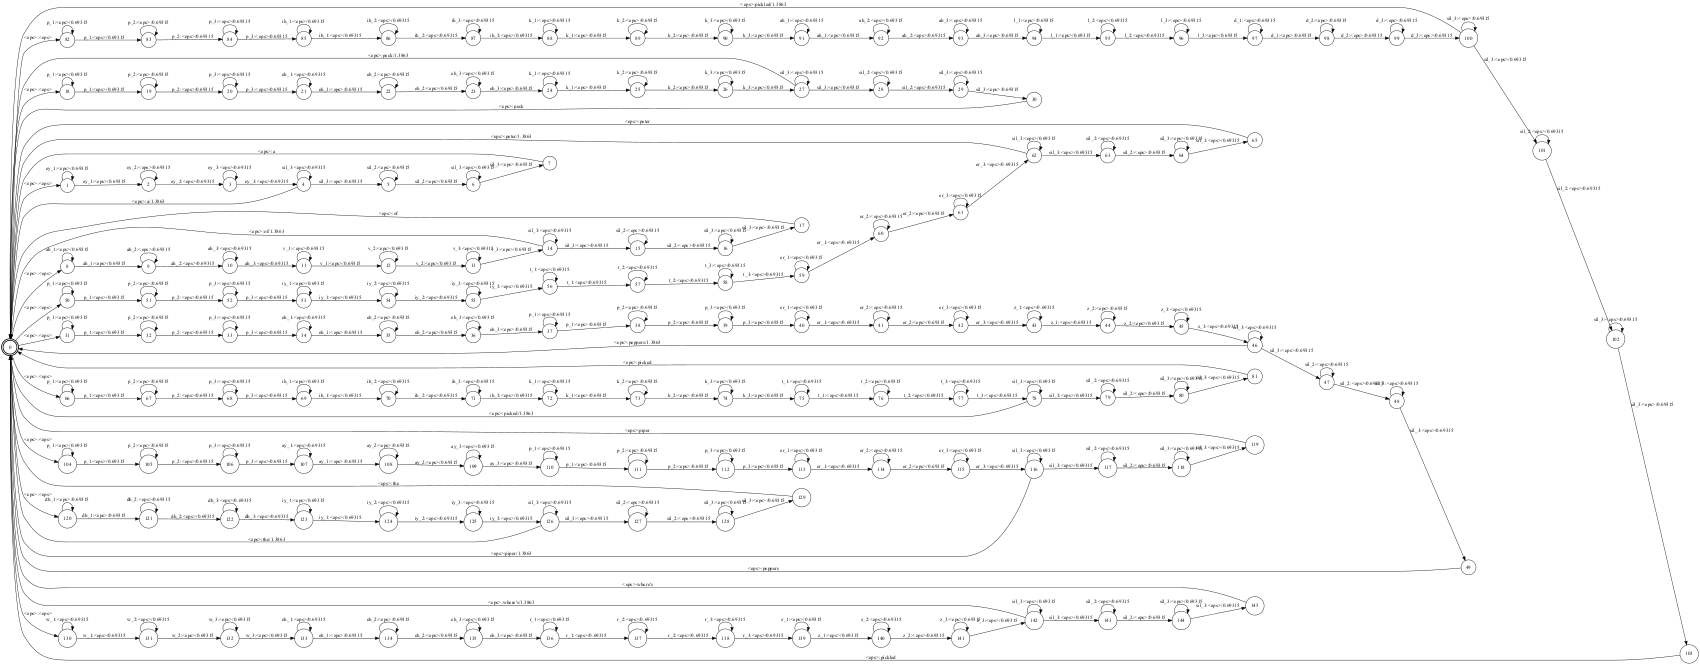

In [51]:
draw_fst(f)

In [52]:
#TASK 2, changing self-loop probabilities
!pip install pandas
import pandas as pd
results_df=[]
import wer
f= create_wfst_silent(3)
print(num_states(f))
print(total_num_arcs(f))

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                           # audio files
    decoder = MyViterbiDecoder(f, wav_file)
    
    forward_computations, decode_speed = decoder.decode()
    print(decode_speed)
    (state_path, words, backtrace_speed) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
    # to return the words along the best path
    print(backtrace_speed)
    
    transcription = read_transcription(wav_file)
    
    word_count = len(transcription.split())
    



    
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())
    worderror = sum(error_counts)/word_count
         # you'll need to accumulate these to produce an overall Word Error Rate
    filename = wav_file.split('/')[-1]
    row = {
        'Filename': filename,
        'Insertions': error_counts[2],
        'Deletions': error_counts[1],
        'Substitutions': error_counts[0],
        'WER': worderror,
        'Word Count': word_count,
        'transcription':transcription,
        'Viterbi transcription':words,
        'Decode speed': decode_speed,
        'Backtrace speed': backtrace_speed,
        'Forward computations': forward_computations
    }
    print(row)
    
    
    # Append results to the DataFrame
    results_df.append(row)
    
results_df = pd.DataFrame(results_df)
# Save the DataFrame to a CSV file
results_df.to_csv('result_silent.csv')



146
300
7.647105932235718
0.0022842884063720703
{'Filename': '0000.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.11764705882352941, 'Word Count': 17, 'transcription': "peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': "pickled peter piper picked a the peck of pickled peppers where's the peck of pickled peppers peter piper picked", 'Decode speed': 7.647105932235718, 'Backtrace speed': 0.0022842884063720703, 'Forward computations': 308628}
5.462110996246338
0.0016217231750488281
{'Filename': '0001.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.42857142857142855, 'Word Count': 7, 'transcription': 'peter picked a peck of pickled peppers', 'Viterbi transcription': 'pickled peter picked the of peck of pickled peppers', 'Decode speed': 5.462110996246338, 'Backtrace speed': 0.0016217231750488281, 'Forward computations': 174978}
4.321821451187134
0.0012230873107910156
{'Filena

6.4813127517700195
0.0007317066192626953
{'Filename': '0020.wav', 'Insertions': 6, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.8571428571428571, 'Word Count': 7, 'transcription': "peppers picked peter piper where's the peck", 'Viterbi transcription': "a peppers picked of peter of piper the a where's the the peck", 'Decode speed': 6.4813127517700195, 'Backtrace speed': 0.0007317066192626953, 'Forward computations': 181998}
6.320285320281982
0.001852273941040039
{'Filename': '0021.wav', 'Insertions': 5, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.6, 'Word Count': 10, 'transcription': 'peter picked a peck piper pickled peppers of pickled peppers', 'Viterbi transcription': 'a peter peck picked of peck piper the of pickled the peppers of pickled peppers', 'Decode speed': 6.320285320281982, 'Backtrace speed': 0.001852273941040039, 'Forward computations': 257868}
4.937349081039429
0.0016567707061767578
{'Filename': '0022.wav', 'Insertions': 9, 'Deletions': 0, 'Substitutions': 1, 'WER': 1.25

2.365391492843628
0.0005464553833007812
{'Filename': '0041.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.42857142857142855, 'Word Count': 7, 'transcription': 'peck pickled piper of the peter peppers', 'Viterbi transcription': 'a peck pickled picked of the peter peppers the', 'Decode speed': 2.365391492843628, 'Backtrace speed': 0.0005464553833007812, 'Forward computations': 96678}
2.943387985229492
0.0008347034454345703
{'Filename': '0042.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.18181818181818182, 'Word Count': 11, 'transcription': 'a peck of pickled peter picked the peppers of the peck', 'Viterbi transcription': 'a of peck of pickled peter peck the peppers of the peck', 'Decode speed': 2.943387985229492, 'Backtrace speed': 0.0008347034454345703, 'Forward computations': 119628}
2.517589807510376
0.00039768218994140625
{'Filename': '0043.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 2, 'WER': 0.5714285714285714, 'Word Count': 7,

2.3638455867767334
0.0001742839813232422
{'Filename': '0061.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.6, 'Word Count': 5, 'transcription': 'peck peppers pickled peter piper', 'Viterbi transcription': 'a a peck peppers pickled peter piper the', 'Decode speed': 2.3638455867767334, 'Backtrace speed': 0.0001742839813232422, 'Forward computations': 96678}
6.614634037017822
0.0019197463989257812
{'Filename': '0062.wav', 'Insertions': 3, 'Deletions': 1, 'Substitutions': 3, 'WER': 0.4117647058823529, 'Word Count': 17, 'transcription': "peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': "a peter of piper picked of picked of pickled peppers where's peck of pickled peppers picked of piper picked", 'Decode speed': 6.614634037017822, 'Backtrace speed': 0.0019197463989257812, 'Forward computations': 243288}
3.3653697967529297
0.00034427642822265625
{'Filename': '0063.wav', 'Insertions': 3, 'Deletion

2.7719271183013916
0.0003287792205810547
{'Filename': '0081.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.2, 'Word Count': 5, 'transcription': "where's peck peppers of piper", 'Viterbi transcription': "a where's peck peppers of piper", 'Decode speed': 2.7719271183013916, 'Backtrace speed': 0.0003287792205810547, 'Forward computations': 110448}
5.240014314651489
0.0005140304565429688
{'Filename': '0082.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 2, 'WER': 1.6666666666666667, 'Word Count': 3, 'transcription': 'piper of peppers', 'Viterbi transcription': "a a the piper picked where's", 'Decode speed': 5.240014314651489, 'Backtrace speed': 0.0005140304565429688, 'Forward computations': 133398}
3.8605287075042725
0.0009915828704833984
{'Filename': '0083.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 1, 'WER': 1.3333333333333333, 'Word Count': 3, 'transcription': 'peter picked piper', 'Viterbi transcription': 'a picked picked picked piper a', 'Decod

6.039897441864014
0.0008654594421386719
{'Filename': '0101.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 2, 'WER': 0.35714285714285715, 'Word Count': 14, 'transcription': "peck piper picked of picked pickled of where's a peppers peter peppers peter pickled", 'Viterbi transcription': "a picked piper picked of peter pickled of where's a the peppers peter peppers peck peter pickled", 'Decode speed': 6.039897441864014, 'Backtrace speed': 0.0008654594421386719, 'Forward computations': 241938}
3.6686370372772217
0.0003597736358642578
{'Filename': '0102.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.25, 'Word Count': 4, 'transcription': 'peppers peck peter pickled', 'Viterbi transcription': 'a peppers peck peter pickled', 'Decode speed': 3.6686370372772217, 'Backtrace speed': 0.0003597736358642578, 'Forward computations': 94248}
4.888784408569336
0.0010776519775390625
{'Filename': '0103.wav', 'Insertions': 1, 'Deletions': 1, 'Substitutions': 0, 'WER': 0.28571428

3.779635190963745
0.0009341239929199219
{'Filename': '0122.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 1, 'WER': 1.0, 'Word Count': 4, 'transcription': 'the peppers peck pickled', 'Viterbi transcription': "a the peck where's peck pickled a", 'Decode speed': 3.779635190963745, 'Backtrace speed': 0.0009341239929199219, 'Forward computations': 103698}
2.5132031440734863
0.0006473064422607422
{'Filename': '0123.wav', 'Insertions': 1, 'Deletions': 1, 'Substitutions': 3, 'WER': 0.8333333333333334, 'Word Count': 6, 'transcription': 'peter of a peck of peppers', 'Viterbi transcription': "a peter pickled pickled peck where's", 'Decode speed': 2.5132031440734863, 'Backtrace speed': 0.0006473064422607422, 'Forward computations': 101268}
2.32047438621521
0.0004062652587890625
{'Filename': '0124.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.8, 'Word Count': 5, 'transcription': 'peter peter peter peter peter', 'Viterbi transcription': 'a peter peter picked of peter 

3.450291633605957
0.0003364086151123047
{'Filename': '0144.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 2, 'WER': 0.625, 'Word Count': 8, 'transcription': 'peter piper picked a peck of pickled peppers', 'Viterbi transcription': 'a a the peter peter picked picked peck of pickled peppers', 'Decode speed': 3.450291633605957, 'Backtrace speed': 0.0003364086151123047, 'Forward computations': 142848}
4.873556852340698
0.0006508827209472656
{'Filename': '0145.wav', 'Insertions': 6, 'Deletions': 0, 'Substitutions': 3, 'WER': 1.0, 'Word Count': 9, 'transcription': "where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': "a where's a picked the peck of the pickled piper where's the picked peck of", 'Decode speed': 4.873556852340698, 'Backtrace speed': 0.0006508827209472656, 'Forward computations': 197928}
2.879483938217163
0.0006909370422363281
{'Filename': '0146.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.3333333333333333, 'Word Count

1.6752328872680664
0.00020432472229003906
{'Filename': '0165.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 1, 'WER': 1.3333333333333333, 'Word Count': 3, 'transcription': 'peter piper picked', 'Viterbi transcription': 'a peter picked picked picked the', 'Decode speed': 1.6752328872680664, 'Backtrace speed': 0.00020432472229003906, 'Forward computations': 66708}
2.978999376296997
0.0003714561462402344
{'Filename': '0166.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 2, 'WER': 0.5, 'Word Count': 8, 'transcription': 'peter piper picked a peck of pickled peppers', 'Viterbi transcription': 'a the of piper picked of peck of pickled peppers', 'Decode speed': 2.978999376296997, 'Backtrace speed': 0.0003714561462402344, 'Forward computations': 119628}
2.4086108207702637
0.0003914833068847656
{'Filename': '0167.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.5, 'Word Count': 6, 'transcription': 'picked a peck of pickled peppers', 'Viterbi transcription': 'a

2.998117208480835
0.0006041526794433594
{'Filename': '0186.wav', 'Insertions': 1, 'Deletions': 1, 'Substitutions': 1, 'WER': 0.5, 'Word Count': 6, 'transcription': 'peter pickled a peck of peppers', 'Viterbi transcription': "a peter pickled peck of where's", 'Decode speed': 2.998117208480835, 'Backtrace speed': 0.0006041526794433594, 'Forward computations': 108018}
1.8331348896026611
0.0002155303955078125
{'Filename': '0187.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 0, 'WER': 1.0, 'Word Count': 3, 'transcription': 'piper pickled peter', 'Viterbi transcription': 'a piper a pickled peter a', 'Decode speed': 1.8331348896026611, 'Backtrace speed': 0.0002155303955078125, 'Forward computations': 72918}
3.6237075328826904
0.00033164024353027344
{'Filename': '0188.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.4, 'Word Count': 5, 'transcription': "where's peter piper pickled peppers", 'Viterbi transcription': "a where's peter piper a pickled peppers", 'Decode 

2.913973569869995
0.0006792545318603516
{'Filename': '0204.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.14285714285714285, 'Word Count': 7, 'transcription': 'peck of pickled peppers peter piper picked', 'Viterbi transcription': 'a peck of pickled peppers peter piper picked', 'Decode speed': 2.913973569869995, 'Backtrace speed': 0.0006792545318603516, 'Forward computations': 112878}
2.6137497425079346
0.0008802413940429688
{'Filename': '0205.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.14285714285714285, 'Word Count': 7, 'transcription': 'peter piper peck peppers picked peter peppers', 'Viterbi transcription': 'a peter piper peck peppers picked peter peppers', 'Decode speed': 2.6137497425079346, 'Backtrace speed': 0.0008802413940429688, 'Forward computations': 105858}
2.7532923221588135
0.00033354759216308594
{'Filename': '0206.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.25, 'Word Count': 8, 'transcription': 'pickled 

2.109250783920288
0.0001766681671142578
{'Filename': '0223.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.14285714285714285, 'Word Count': 7, 'transcription': "piper picked peter pickled where's the peppers", 'Viterbi transcription': "a piper picked peter pickled where's the peppers", 'Decode speed': 2.109250783920288, 'Backtrace speed': 0.0001766681671142578, 'Forward computations': 85068}
1.5518255233764648
0.0002009868621826172
{'Filename': '0224.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.16666666666666666, 'Word Count': 6, 'transcription': 'the peck of piper peter picked', 'Viterbi transcription': 'a the peck of piper peter picked', 'Decode speed': 1.5518255233764648, 'Backtrace speed': 0.0002009868621826172, 'Forward computations': 64278}
1.9588611125946045
0.00030112266540527344
{'Filename': '0225.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.2857142857142857, 'Word Count': 7, 'transcription': 'piper peter peter 

5.279860496520996
0.0014951229095458984
{'Filename': '0244.wav', 'Insertions': 6, 'Deletions': 0, 'Substitutions': 3, 'WER': 1.2857142857142858, 'Word Count': 7, 'transcription': 'peter picked a peck of pickled peppers', 'Viterbi transcription': "a of a a a of a the of peck of pickled where's", 'Decode speed': 5.279860496520996, 'Backtrace speed': 0.0014951229095458984, 'Forward computations': 197928}
5.184008836746216
0.0011696815490722656
{'Filename': '0245.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 3, 'WER': 1.4, 'Word Count': 5, 'transcription': 'the pickled peppers peter picked', 'Viterbi transcription': "a the where's picked of where's picked of the", 'Decode speed': 5.184008836746216, 'Backtrace speed': 0.0011696815490722656, 'Forward computations': 140418}
2.2041406631469727
0.00013828277587890625
{'Filename': '0246.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 0, 'WER': 1.0, 'Word Count': 3, 'transcription': "where's the piper", 'Viterbi transcription': 

2.4166526794433594
0.00015616416931152344
{'Filename': '0263.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.6666666666666666, 'Word Count': 6, 'transcription': 'peter picked peck of pickled peppers', 'Viterbi transcription': 'a the picked of peck peck of pickled peppers', 'Decode speed': 2.4166526794433594, 'Backtrace speed': 0.00015616416931152344, 'Forward computations': 98838}
1.9152827262878418
0.00011897087097167969
{'Filename': '0264.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.75, 'Word Count': 4, 'transcription': "where's peter piper peck", 'Viterbi transcription': "a where's picked of piper peck", 'Decode speed': 1.9152827262878418, 'Backtrace speed': 0.00011897087097167969, 'Forward computations': 78318}
1.8047738075256348
0.00011229515075683594
{'Filename': '0265.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 2, 'WER': 1.3333333333333333, 'Word Count': 3, 'transcription': 'piper picked peppers', 'Viterbi transcription': "a

1.8511502742767334
0.0007185935974121094
{'Filename': '0285.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.5, 'Word Count': 4, 'transcription': "where's the peck peter", 'Viterbi transcription': "a where's the peck peter picked", 'Decode speed': 1.8511502742767334, 'Backtrace speed': 0.0007185935974121094, 'Forward computations': 73728}
2.0311665534973145
0.0002944469451904297
{'Filename': '0286.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.3333333333333333, 'Word Count': 3, 'transcription': 'piper pickled peppers', 'Viterbi transcription': 'a piper pickled peppers', 'Decode speed': 2.0311665534973145, 'Backtrace speed': 0.0002944469451904297, 'Forward computations': 80478}
2.5938591957092285
0.00024509429931640625
{'Filename': '0287.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.5, 'Word Count': 8, 'transcription': 'a peck of pickled peppers peter piper picked', 'Viterbi transcription': "a of peck of pickled the of where'

3.181591033935547
0.00032806396484375
{'Filename': '0307.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 2, 'WER': 0.5, 'Word Count': 6, 'transcription': 'the peppers pickled peter peppers piper', 'Viterbi transcription': 'a picked peppers pickled peter peppers peppers', 'Decode speed': 3.181591033935547, 'Backtrace speed': 0.00032806396484375, 'Forward computations': 82908}
2.108095645904541
0.0003445148468017578
{'Filename': '0308.wav', 'Insertions': 5, 'Deletions': 0, 'Substitutions': 2, 'WER': 1.1666666666666667, 'Word Count': 6, 'transcription': 'peppers peck peppers picked peppers peter', 'Viterbi transcription': "a peck of where's peck peppers picked of where's peter the", 'Decode speed': 2.108095645904541, 'Backtrace speed': 0.0003445148468017578, 'Forward computations': 87498}
12.14859676361084
0.0028913021087646484
{'Filename': '0309.wav', 'Insertions': 10, 'Deletions': 0, 'Substitutions': 4, 'WER': 0.875, 'Word Count': 16, 'transcription': 'peter piper picked a peck 

2.325986623764038
0.00015592575073242188
{'Filename': '0328.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 5, 'WER': 0.7777777777777778, 'Word Count': 9, 'transcription': "where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': "a where's of peck of picked of where's peter where's a", 'Decode speed': 2.325986623764038, 'Backtrace speed': 0.00015592575073242188, 'Forward computations': 96678}


In [ ]:
#task 3 pruning

#attempt using beam search
"""
what is beam search?




"""
class PrunedViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name,beam=30 beam_type = "size"):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        self.beam = beam
        self.beam_type = beam_type
        if beam_type != "size" or beam_type != "width":
            raise Exception("beam_type must be of size or width")
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        
        forward_computations = 0
          
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        forward_computations += 1
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                                
        return forward_computations
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        forward_computations = 0
        initial = time.time()
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            forward_computations += self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
        final=time.time()
        return (forward_computations, (final - initial))
    
    def backtrace(self):
        
        initial = time.time()
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        
        
        final = time.time()
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence =' '.join([ self.f.output_symbols().find(label) for label in best_out_sequence])
        return (best_state_sequence, best_out_sequence,(final-initial))
    


In [59]:
#task 4
#Bigram Probabilities

from collections import defaultdict
bigram_count=defaultdict(int)
word_count = defaultdict(int)


for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                           # audio files
    transcription = read_transcription(wav_file)
    transcription = "<s> "+ str(transcription)+" </s>"
    transcription = transcription.split(" ")
    for i in range(1,len(transcription)):
        bigram = transcription[i-1]+ " "+transcription[i]
        print(bigram)
        
total_words = sum(word_count.values())
# probabilities ={bigram:count/total_words for word,count in word_count.items()}
# print(word_count,bigram_probabilities)

<s> peter
peter piper
piper picked
picked a
a peck
peck of
of pickled
pickled peppers
peppers where's
where's the
the peck
peck of
of pickled
pickled peppers
peppers peter
peter piper
piper picked
picked </s>
<s> peter
peter picked
picked a
a peck
peck of
of pickled
pickled peppers
peppers </s>
<s> a
a peck
peck of
of pickled
pickled peppers
peppers picked
picked </s>
<s> peter
peter piper
piper peter
peter piper
piper </s>
<s> where's
where's the
the peck
peck of
of pickled
pickled peppers
peppers picked
picked </s>
<s> peter
peter piper
piper pickled
pickled peppers
peppers </s>
<s> where's
where's peter
peter </s>
<s> piper
piper picked
picked peppers
peppers of
of peter
peter </s>
<s> peter
peter peppers
peppers picked
picked piper
piper of
of peck
peck </s>
<s> a
a peck
peck of
of pickled
pickled peppers
peppers peter
peter piper
piper pickled
pickled </s>
<s> picked
picked </s>
<s> pickled
pickled </s>
<s> peppers
peppers </s>
<s> piper
piper </s>
<s> peter
peter </s>
<s> where's